In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

iris = datasets.load_iris()

df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df["target"] = iris.target
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


    1. АНАЛИЗ

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [3]:
df.describe(include = "all")

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


Построим несколько графиков для анализа данных

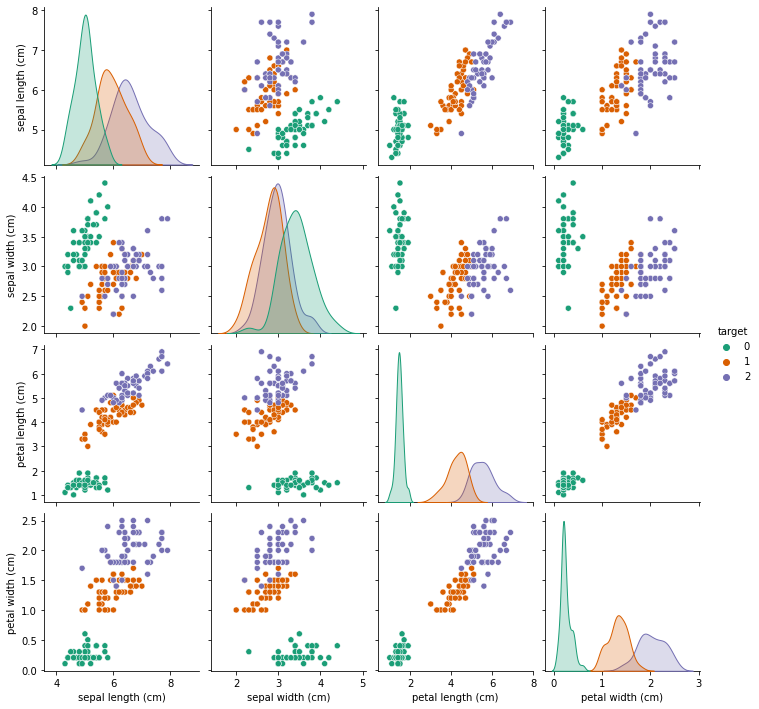

In [4]:
sns.pairplot(df,hue='target',palette='Dark2');

Так как у нас задача классификации и 1 из решений таких задач может быть разделение на координатной прямой (проведение линии) для определения класса n объекта (например SVM). Как видим, если придерживаться такого подхода, то найменее подходящим является сочитание sepal width (cm) и sepal length (cm). Так как данные там очень "смешаны". (если target = 1 хорошо выделяется, то target = 2,3 - нет)

Определим коофиценты корреляции для каждого значения.

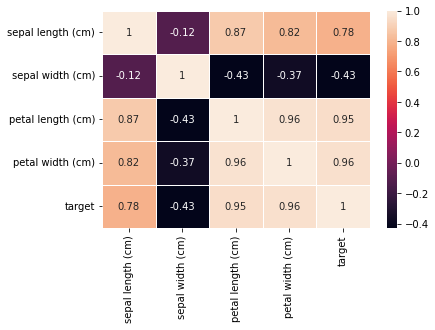

In [5]:
df2 = df.copy()
corr = df2.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns, annot = True,
            linewidths=.5);

Взаимосвязь значений petal length (cm), petal width (cm) и target слишком большие. Поэтому их убираем из датасета

In [6]:
df = df.drop(columns = ["petal width (cm)", "petal length (cm)"])

    2. РАЗБИЕНИЕ

In [7]:
from sklearn.model_selection import train_test_split
X = df.drop(columns = ["target"])
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.sort_index().head()

,sepal length (cm),sepal width (cm)
0,5.1,3.5
1,4.9,3.0
2,4.7,3.2
3,4.6,3.1
4,5.0,3.6


In [8]:
y

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: target, Length: 150, dtype: int64

In [9]:
X_test.sort_index().head()

,sepal length (cm),sepal width (cm)
9,4.9,3.1
12,4.8,3.0
18,5.7,3.8
19,5.1,3.8
26,5.0,3.4


    3. ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ

In [10]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression().fit(X_train, y_train)
y_pred = reg.predict_proba(X_test)

Найдем метрику ROC_AUC

In [11]:
from sklearn.metrics import roc_auc_score

array = roc_auc_score(y_test, y_pred, multi_class='ovr')
array

0.9662455802806681

И нарисуем график AUC

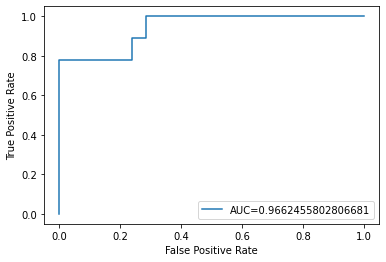

In [12]:
from sklearn.metrics import roc_curve

y_pred_proba = y_pred[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba, pos_label=1)

plt.plot(fpr,tpr,label="AUC="+str(array))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [13]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42) # n_splits играет роль K
reg = LogisticRegression()

In [14]:
scores = cross_val_score(reg, X, y, cv=kf, scoring= 'roc_auc_ovr')
print('Массив значений метрики:', scores)
print('Средняя метрика на кросс-валидации:', np.mean(scores))

Массив значений метрики: [0.96624558 0.92253106 0.92136364 0.92759259 0.89973566]
Средняя метрика на кросс-валидации: 0.9274937051676183


In [15]:
scores = cross_val_score(reg, X, y, cv=kf, scoring= 'roc_auc_ovo')
print('Массив значений метрики:', scores)
print('Средняя метрика на кросс-валидации:', np.mean(scores))

Массив значений метрики: [0.96632997 0.9        0.90625    0.9375     0.91504329]
Средняя метрика на кросс-валидации: 0.9250246512746513


In [16]:
scores = cross_val_score(reg, X, y, cv=kf, scoring= 'roc_auc_ovo_weighted')
print('Массив значений метрики:', scores)
print('Средняя метрика на кросс-валидации:', np.mean(scores))

Массив значений метрики: [0.96632997 0.915      0.915625   0.93125    0.90471681]
Средняя метрика на кросс-валидации: 0.9265843554593554


    4. SVM и GridSearchCV.

Для нахождения лучших гипер-параметров для SVM воспользуемся GridSearchCV.

In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'C':[0.1,1,10,20],'kernel':['rbf','poly','sigmoid','linear'],'gamma': [1, 0.1, 0.01, 0.001]}
# словарь параметров (ключ: набор возможных значений)

grid = GridSearchCV(SVC(),param_grid)
grid.fit(X_train,y_train)
print("Лучшие параметры", grid.best_params_)
print("Наилучшая оценка качества модели:", grid.best_score_)

Лучшие параметры {'C': 10, 'gamma': 0.01, 'kernel': 'sigmoid'}
Наилучшая оценка качества модели: 0.7916666666666666


Для лучшей и более детальной информации о результатов каждого гипер-параметра по отдельности.

In [18]:
grid.cv_results_

{'mean_fit_time': array([0.00284805, 0.00929937, 0.00302296, 0.00383158, 0.00413284,
        0.00529461, 0.00540895, 0.00350699, 0.00672245, 0.00336642,
        0.00269918, 0.0025538 , 0.0027153 , 0.0025382 , 0.00284333,
        0.00228829, 0.00237622, 0.06609459, 0.00297966, 0.00250001,
        0.00244508, 0.0024529 , 0.0033103 , 0.00250721, 0.00360436,
        0.00561461, 0.00482736, 0.00279436, 0.00258808, 0.00261588,
        0.00236206, 0.00223513, 0.00225644, 0.5446578 , 0.00242753,
        0.00284238, 0.00227818, 0.00277481, 0.00290279, 0.00270538,
        0.00318813, 0.00311284, 0.00296073, 0.00285172, 0.00336623,
        0.00307713, 0.00357952, 0.0029624 , 0.00318542, 1.12308455,
        0.00567183, 0.00493226, 0.0048882 , 0.00712795, 0.00822358,
        0.00448413, 0.00534401, 0.00485497, 0.00428309, 0.0036818 ,
        0.00624499, 0.01146731, 0.01204   , 0.00636454]),
 'std_fit_time': array([5.76998706e-04, 5.10428946e-03, 8.97596187e-04, 1.49071878e-03,
        1.08288693e-0

    5. ОТВЕТЫ НА ВОПРОСЫ

    1 Какие подходы позволяют логистической регрессии работать на нескольких классах?

multi_class — строка (по умолчанию ovr), которая определяет подход к использованию нескольких классов. Другие варианты — multinomial и auto

    2 Какие значения gamma, C, kernel были наилучшими?

'gamma': 0.01
'C': 10
'kernel': 'sigmoid'